## Обнаружение объектов на изображениях с помощью модели SSD Lite

Архитектура:

- SSDLite (Single Shot MultiBox Detector Lite) — это легковесная версия архитектуры SSD, предназначенная для эффективного обнаружения объектов в реальном времени.
- MobileNet V3 — это сверточная нейронная сеть, оптимизированная для мобильных и встроенных устройств. Она использует архитектуру глубинных сепарабельных сверток для уменьшения числа параметров и вычислительных затрат.

Обучение:

Модель была обучена на наборе данных COCO (Common Objects in Context), который содержит более 330 тысяч изображений и более 2.5 миллиона аннотаций объектов. COCO охватывает 80 различных классов, включая людей, животных и предметы.

Веса:

COCO_V1 — это предобученные веса, которые позволяют модели начинать с уже изученных характеристик объектов, что значительно сокращает время и ресурсы, необходимые для обучения с нуля.

Как работает:

Модель принимает на вход изображение и разбивает его на сетку. Каждая ячейка сетки предсказывает вероятности наличия объекта и координаты его ограничивающего прямоугольника (bounding box).
Затем модель фильтрует предсказания по порогу уверенности и выводит классы и местоположение обнаруженных объектов.

In [61]:
import torch
from torchvision.models.detection import ssdlite320_mobilenet_v3_large, SSDLite320_MobileNet_V3_Large_Weights
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [81]:
# Загрузка предобученной модели SSD

model = ssdlite320_mobilenet_v3_large(weights=SSDLite320_MobileNet_V3_Large_Weights.COCO_V1)
model.eval()


# Функция для предобработки изображения

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = SSDLite320_MobileNet_V3_Large_Weights.COCO_V1.transforms()
    image = transform(image)
    return image.unsqueeze(0)

In [75]:
# Массив названий классов COCO
# https://github.com/amikelive/coco-labels/blob/master/coco-labels-paper.txt

class_names = [
    "person", "bicycle", "car", "motorcycle", "airplane",
    "bus", "train", "truck", "boat", "traffic light",
    "fire hydrant", 'street light', "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow",
    "elephant", "bear", "zebra", "giraffe", "backpack",
    "umbrella", "handbag", "tie", "suitcase", "frisbee",
    "skis", "snowboard", "sports ball", "kite", "baseball bat",
    "baseball glove", "skateboard", "surfboard", "tennis racket",
    "bottle", "wine glass", "cup", "fork", "knife",
    "spoon", "bowl", "banana", "apple", "sandwich",
    "orange", "broccoli", "carrot", "hot dog", "pizza",
    "donut", "cake", "chair", "couch", "potted plant",
    "bed", "dining table", "toilet", "tv", "laptop",
    "mouse", "remote", "keyboard", "cell phone", "microwave",
    "oven", "toaster", "sink", "refrigerator", "book",
    "clock", "vase", "scissors", "teddy bear", "hair drier",
    "toothbrush"
]

In [79]:
# Путь к изображениям

image_paths = [
    "/Users/defrekasik/Downloads/car_and_woman.jpeg",
    "/Users/defrekasik/Downloads/kitty.jpeg",
    "/Users/defrekasik/Downloads/cars.jpg",
    "/Users/defrekasik/Downloads/people.jpg",
    "/Users/defrekasik/Downloads/horses.jpg",
    "/Users/defrekasik/Downloads/dog_and_cat.jpg"
]

In [78]:
def detect_objects(image_path):

    image = preprocess_image(image_path)

    # Выполнение предсказания
    
    with torch.no_grad():
        prediction = model(image)

    # Извлечение данных из предсказания
    
    boxes = prediction[0]['boxes'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()

    # Фильтрация по порогу уверенности
    
    confidence_threshold = 0.4
    filtered_indices = scores > confidence_threshold
    filtered_boxes = boxes[filtered_indices]
    filtered_scores = scores[filtered_indices]
    filtered_labels = labels[filtered_indices]

    # Отображение изображения с предсказанными объектами
    
    image_orig = cv2.imread(image_path)
    for box, score, label in zip(filtered_boxes, filtered_scores, filtered_labels):
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(image_orig, (x1, y1), (x2, y2), (0, 255, 0), 2)

        label_index = label.item()
        if 0 <= label_index < len(class_names):
            class_name = class_names[label_index - 1]
        else:
            class_name = "Unknown"

        text = f"{class_name}: {score:.2f}"
        cv2.putText(image_orig, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Демонстрация изображения
    
    plt.imshow(cv2.cvtColor(image_orig, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

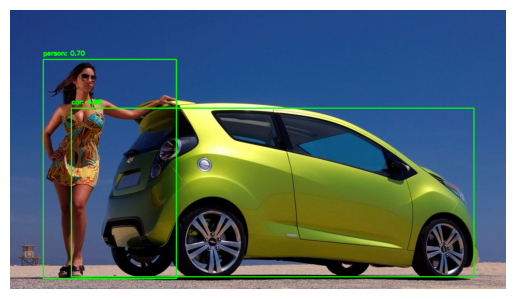

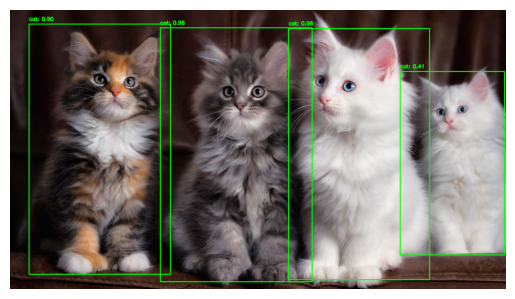

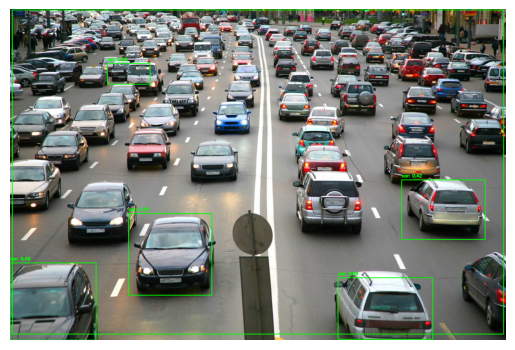

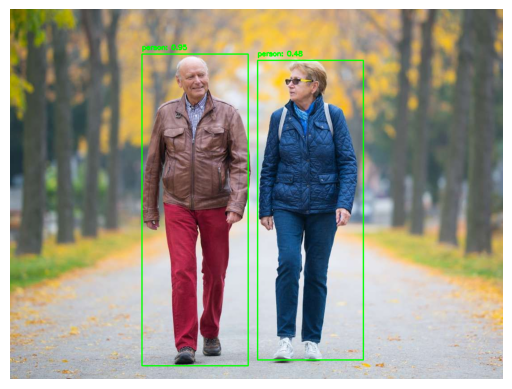

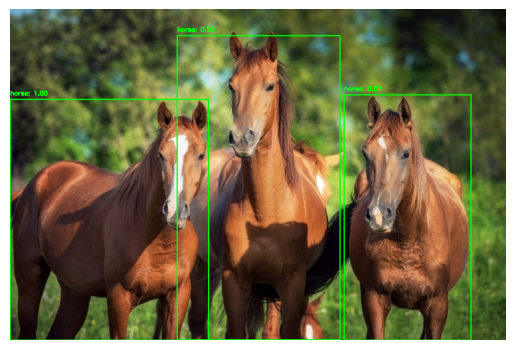

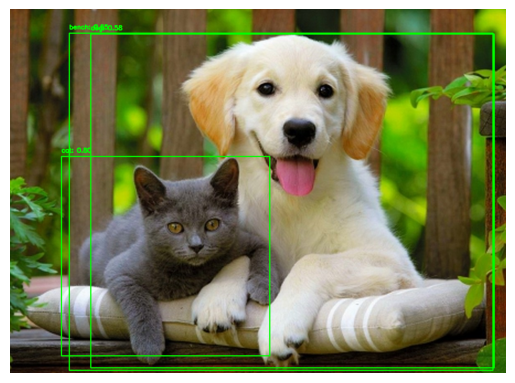

In [80]:
for path in image_paths:
    detect_objects(path)

### Вывод:

Модель корректно обнаруживает объекты и определяет их классы. Её можно использовать для дальнейшей работы — в частности, дообучить полную версию сети на наших данных с рентгеновскими снимками. Это позволит адаптировать модель к специфике медицинских изображений и повысить её точность в распознавании патологий легких.